In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import heapq
import copy
import os
import sys

from sklearn.model_selection import train_test_split

from TCN_Attention import *

In [103]:
data = pd.read_csv('Main_Dataset_std4.csv')
data = data.drop(['Unnamed: 0','SATURATOR1_ML_SUPPLY_F_PV.Value','SATURATOR2_ML_SUPPLY_F_PV.Value'], axis = 1)

In [104]:
stage1 = ['Pol', 'IS', 'Moisture', 'Ash', 'Filterability', 'Color', 'Alcohol_Floc', 'MELTER.MELTER_CONTROL_BX.Value', 'MELTER_ML.TEMP_PV_Value']
stage2 = ['CO2.CO2_GAS_F.Value', 'CO2.CO2_GAS_PRESS.Value', 'CO2.CO2_GAS_concentration_Value', 'SATURATOR1_PH_PV.Value', 'SATURATOR1_ST_TEMP.Value', 'SATURATOR1_CALCIUM_F.Value', 'SATURATOR1_RATE_SV.Value','SATURATOR2_PH_PV.Value', 'SATURATOR2_ST_TEMP.Value', 'SATURATOR2_CALCIUM_F.Value','Saturator1_exp_CaO', 'Saturator2_exp_CaO']
stage3 = ['SATURATOR3_PH_PV.Value', 'SATURATOR3_ST_TEMP.Value','Saturator3_exp_CaO']
date = ['TimeStamp']
target = ['SATURATOR_ML_SUPPLY_F_PV.Value']

In [105]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [106]:
len(stage1),len(stage2),len(stage3)

(9, 12, 3)

In [107]:
data = data[date + stage1 + stage2 + stage3 + target] 

In [108]:
train, valid = train_test_split(data, test_size = 0.2, train_size = 0.8, shuffle=False)
valid, test =  train_test_split(valid, test_size = 0.5, train_size = 0.5, shuffle=False)

In [109]:
valid.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [147]:
def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    y_target = df_[target].copy()
    data_list = []
    dap_list = []
    date_list = []
    y_shift = df_[target].copy(deep=True).shift(periods=1, axis=0)
    y_shift = y_shift.fillna(0.)
    df_[target] = y_shift
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.iloc[idx:idx+window_size,np.arange(1,26)].values.reshape(window_size, 25)
        y = y_target.iloc[idx+window_size-1:idx+window_size+forcast_size-1].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data():
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [148]:
window_size = 8
forcast_size = 1
batch_size = 64
targets = 'SATURATOR_ML_SUPPLY_F_PV.Value'
date = 'TimeStamp'

train_x, train_y, train_date = time_slide_df(train, window_size, forcast_size, date, targets)
val_x, val_y, val_date = time_slide_df(valid, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test, window_size, forcast_size, date, targets)

In [150]:
train_ds = Data(train_x, train_y)
valid_ds = Data(val_x, val_y)
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size = val_x.shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

### Linear로 넘기기

In [174]:
class MultiStageForecasting(nn.Module):
    def __init__(self, len_stage1, len_stage2, len_stage3, window_size, forcast_size):
        super(MultiStageForecasting, self).__init__()
        self.len_stage1 = len_stage1
        self.len_stage2 = len_stage2
        self.len_stage3 = len_stage3
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.linear = nn.Linear(self.window_size, self.forcast_size)
        self.linear_st1 = nn.Linear(self.len_stage1, self.len_stage1//3)
        self.linear_st2 = nn.Linear(self.len_stage2 + self.len_stage1//3, (self.len_stage2 + self.len_stage1//3)//3)
        self.linear_st3 = nn.Linear((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3, ((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2)
        self.linear_out = nn.Linear(((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2 + 1, 1)

        self.out_Linear = torch.nn.Linear(self.window_size, self.forcast_size)
        

    def forward(self, x):
        stage1 = x[:,:,:self.len_stage1]
        stage2 = x[:,:,self.len_stage1:self.len_stage1 + self.len_stage2]
        stage3 = x[:,:,self.len_stage1 + self.len_stage2: self.len_stage1 + self.len_stage2 + self.len_stage3]
        target_slide = x[:,:,self.len_stage1 + self.len_stage2 + self.len_stage3:]
        out_stage1 = self.linear_st1(stage1)
        stage2 = torch.cat([out_stage1,stage2],dim=2)
        out_stage2 = self.linear_st2(stage2)
        stage3 = torch.cat([out_stage2,stage3],dim=2)
        out_stage3 = self.linear_st3(stage3)
        out = torch.cat([out_stage3,target_slide],dim=2)
        out = self.linear_out(out)

        x = self.out_Linear(out.permute(0,2,1)).permute(0,2,1)

        return x



### 변수별 시간 개무시하기

In [186]:
class MultiStageForecasting_2(nn.Module):
    def __init__(self, len_stage1, len_stage2, len_stage3, window_size, forcast_size):
        super(MultiStageForecasting_2, self).__init__()
        self.len_stage1 = len_stage1
        self.len_stage2 = len_stage2
        self.len_stage3 = len_stage3
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.linear = nn.Linear(self.window_size, self.forcast_size)
        self.linear_st1 = nn.Linear(self.len_stage1, self.len_stage1//3)
        self.linear_st2 = nn.Linear(self.len_stage2 + self.len_stage1//3, (self.len_stage2 + self.len_stage1//3)//3)
        self.linear_st3 = nn.Linear((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3, ((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2)

        self.Linears = torch.nn.ModuleList()
        for i in range(((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2 + 1):
            self.Linears.append(torch.nn.Linear(self.window_size, self.forcast_size))


        self.out_Linear = torch.nn.Linear(((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2 + 1, self.forcast_size)
        
        

    def forward(self, x):
        stage1 = x[:,:,:self.len_stage1]
        stage2 = x[:,:,self.len_stage1:self.len_stage1 + self.len_stage2]
        stage3 = x[:,:,self.len_stage1 + self.len_stage2: self.len_stage1 + self.len_stage2 + self.len_stage3]
        out_stage1 = self.linear_st1(stage1)
        stage2 = torch.cat([out_stage1,stage2],dim=2)
        out_stage2 = self.linear_st2(stage2)
        stage3 = torch.cat([out_stage2,stage3],dim=2)
        out_stage3 = self.linear_st3(stage3)
        out = torch.cat([out_stage3,target_slide],dim=2)

        output = torch.zeros([out.size(0),self.forcast_size,out.size(2)],dtype=x.dtype).to(x.device)

        for i in range(((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2 + 1):
            output[:,:,i] = self.Linears[i](out[:,:,i])

        x = self.out_Linear(output)
        
        return x



In [175]:
### 모델 학습 ###
from tqdm.auto import tqdm

train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 100
lr = 0.001
patience_limit = 3
patience_check = 0
model = MultiStageForecasting(len_stage1 = 9, len_stage2 = 12, len_stage3 = 3, window_size=window_size,
                            forcast_size=forcast_size,
                            ).to(device)
                            
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 10**10

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output.to(device), target.to(device).unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = model(data.to(device))
            valid_loss = criterion(output.to(device), target.to(device).unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        
        for data, target in test_dl:
            output = model(data.to(device))
            test_loss = criterion(output, target.to(device).unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss > max_loss: # loss가 개선되지 않은 경우
        patience_check += 1

        if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
            print('Early Stopping')
            break

    else: # loss가 개선된 경우
        max_loss = valid_loss
        patience_check = 0
    
    print("epoch = {}, train_loss(RMSE) : {:.3f}, valid_loss(RMSE) : {:.3f}, test_loss(RMSE) : {:.3f}".format(epoch,
                                                                                                                torch.sqrt(torch.mean(torch.Tensor(loss_list))),
                                                                                                                torch.sqrt(torch.Tensor(valid_loss)),
                                                                                                                torch.sqrt(torch.Tensor(test_loss))
                                                                                                                )
                                                                                                                )

  0%|          | 0/100 [00:00<?, ?it/s]

epoch = 1, train_loss(RMSE) : 16.708, valid_loss(RMSE) : 19.866, test_loss(RMSE) : 15.668
epoch = 2, train_loss(RMSE) : 9.258, valid_loss(RMSE) : 13.800, test_loss(RMSE) : 12.145
epoch = 3, train_loss(RMSE) : 7.801, valid_loss(RMSE) : 9.619, test_loss(RMSE) : 9.888
epoch = 4, train_loss(RMSE) : 6.726, valid_loss(RMSE) : 6.883, test_loss(RMSE) : 8.577
epoch = 5, train_loss(RMSE) : 6.130, valid_loss(RMSE) : 6.146, test_loss(RMSE) : 7.861
epoch = 6, train_loss(RMSE) : 5.717, valid_loss(RMSE) : 5.819, test_loss(RMSE) : 7.199
epoch = 7, train_loss(RMSE) : 5.381, valid_loss(RMSE) : 5.559, test_loss(RMSE) : 6.660
epoch = 8, train_loss(RMSE) : 5.112, valid_loss(RMSE) : 5.322, test_loss(RMSE) : 6.239
epoch = 9, train_loss(RMSE) : 4.888, valid_loss(RMSE) : 5.101, test_loss(RMSE) : 5.910
epoch = 10, train_loss(RMSE) : 4.687, valid_loss(RMSE) : 4.896, test_loss(RMSE) : 5.661
epoch = 11, train_loss(RMSE) : 4.511, valid_loss(RMSE) : 4.713, test_loss(RMSE) : 5.468
epoch = 12, train_loss(RMSE) : 4.362

In [176]:
model.eval()
prediction_1 = torch.cat([model(x.to(device)).detach().cpu() for x, y in test_dl], axis=0)
actual = torch.cat([y for x, y in test_dl], axis=0)

In [177]:
prediction_1 = prediction_1.squeeze().numpy()
actual = actual.squeeze().numpy()

In [178]:
mse_1 = sum((prediction_1-actual)**2)/len(prediction_1)
print(mse_1)

17.38742532844594


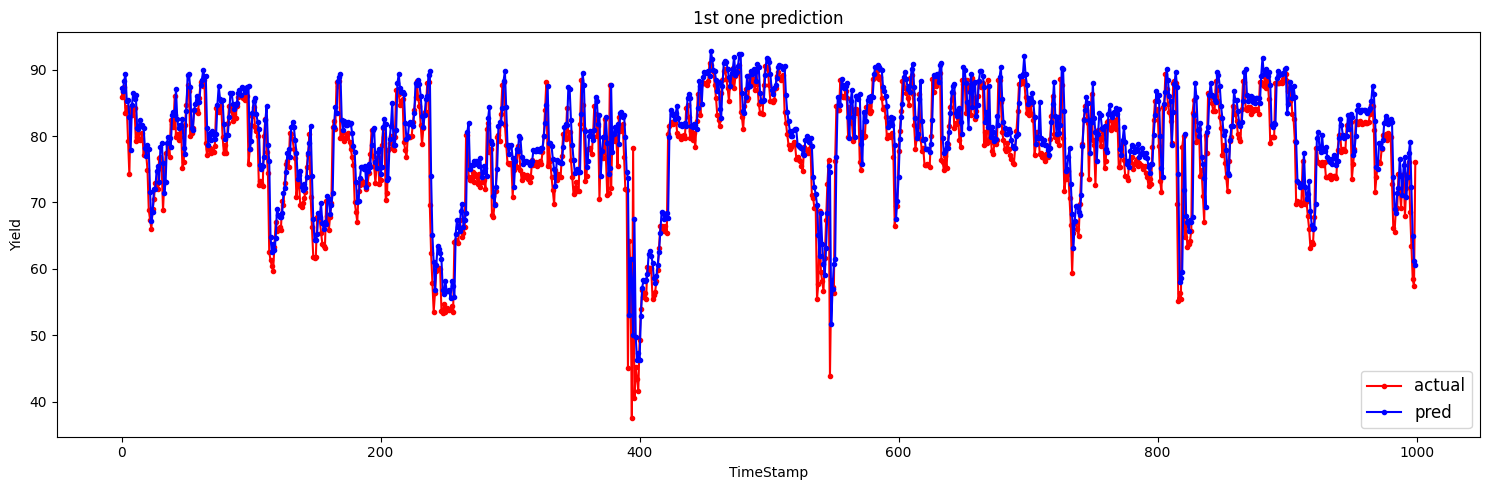

In [179]:
plt.figure(figsize=(15,5), dpi=100) #Figure size and dpi

plt.title('1st one prediction')
plt.plot( np.arange(1000), actual[-1000:], label = 'actual', color = 'red', marker='o', linestyle = '-', markersize=3) # Real value
plt.plot( np.arange(1000), prediction_1[-1000:], label = 'pred', color = 'blue', marker='o', linestyle = '-', markersize=3) # Real value

plt.ylabel('Yield')
plt.xlabel('TimeStamp')
plt.legend(fontsize = 12, markerscale =1, loc = 'lower right')
plt.tight_layout()
plt.show()

In [187]:
### 모델 학습 ###
from tqdm.auto import tqdm

train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 100
lr = 0.001
model_2 = MultiStageForecasting_2(len_stage1 = 9, len_stage2 = 12, len_stage3 = 3, window_size=window_size,
                            forcast_size=forcast_size,
                            ).to(device)
                            
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)
max_loss = 10**10

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    model_2.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model_2(data.to(device))
        loss = criterion(output.to(device), target.to(device).unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    model_2.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = model_2(data.to(device))
            valid_loss = criterion(output.to(device), target.to(device).unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        
        for data, target in test_dl:
            output = model_2(data.to(device))
            test_loss = criterion(output, target.to(device).unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss > max_loss: # loss가 개선되지 않은 경우
        patience_check += 1

        if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
            print('Early Stopping')
            break

    else: # loss가 개선된 경우
        max_loss = valid_loss
        patience_check = 0
    
    print("epoch = {}, train_loss(RMSE) : {:.3f}, valid_loss(RMSE) : {:.3f}, test_loss(RMSE) : {:.3f}".format(epoch,
                                                                                                                torch.sqrt(torch.mean(torch.Tensor(loss_list))),
                                                                                                                torch.sqrt(torch.Tensor(valid_loss)),
                                                                                                                torch.sqrt(torch.Tensor(test_loss))
                                                                                                                )
                                                                                                                )

  0%|          | 0/100 [00:00<?, ?it/s]

epoch = 1, train_loss(RMSE) : 18.436, valid_loss(RMSE) : 9.327, test_loss(RMSE) : 13.699
epoch = 2, train_loss(RMSE) : 8.241, valid_loss(RMSE) : 7.750, test_loss(RMSE) : 11.092
epoch = 3, train_loss(RMSE) : 6.540, valid_loss(RMSE) : 7.359, test_loss(RMSE) : 10.098
epoch = 4, train_loss(RMSE) : 5.737, valid_loss(RMSE) : 6.852, test_loss(RMSE) : 9.225
epoch = 5, train_loss(RMSE) : 5.286, valid_loss(RMSE) : 6.121, test_loss(RMSE) : 8.290
epoch = 6, train_loss(RMSE) : 4.976, valid_loss(RMSE) : 5.464, test_loss(RMSE) : 7.440
epoch = 7, train_loss(RMSE) : 4.715, valid_loss(RMSE) : 4.941, test_loss(RMSE) : 6.682
epoch = 8, train_loss(RMSE) : 4.486, valid_loss(RMSE) : 4.533, test_loss(RMSE) : 6.012
epoch = 9, train_loss(RMSE) : 4.286, valid_loss(RMSE) : 4.216, test_loss(RMSE) : 5.428
epoch = 10, train_loss(RMSE) : 4.116, valid_loss(RMSE) : 3.975, test_loss(RMSE) : 4.938
epoch = 11, train_loss(RMSE) : 3.972, valid_loss(RMSE) : 3.804, test_loss(RMSE) : 4.567
epoch = 12, train_loss(RMSE) : 3.852,

In [188]:
model_2.eval()
prediction_2 = torch.cat([model_2(x.to(device)).detach().cpu() for x, y in test_dl], axis=0)
actual = torch.cat([y for x, y in test_dl], axis=0)

In [189]:
prediction_2 = prediction_2.squeeze().numpy()
actual = actual.squeeze().numpy()

In [190]:
mse_2 = sum((prediction_2-actual)**2)/len(prediction_2)
print(mse_2)

12.351866325874102


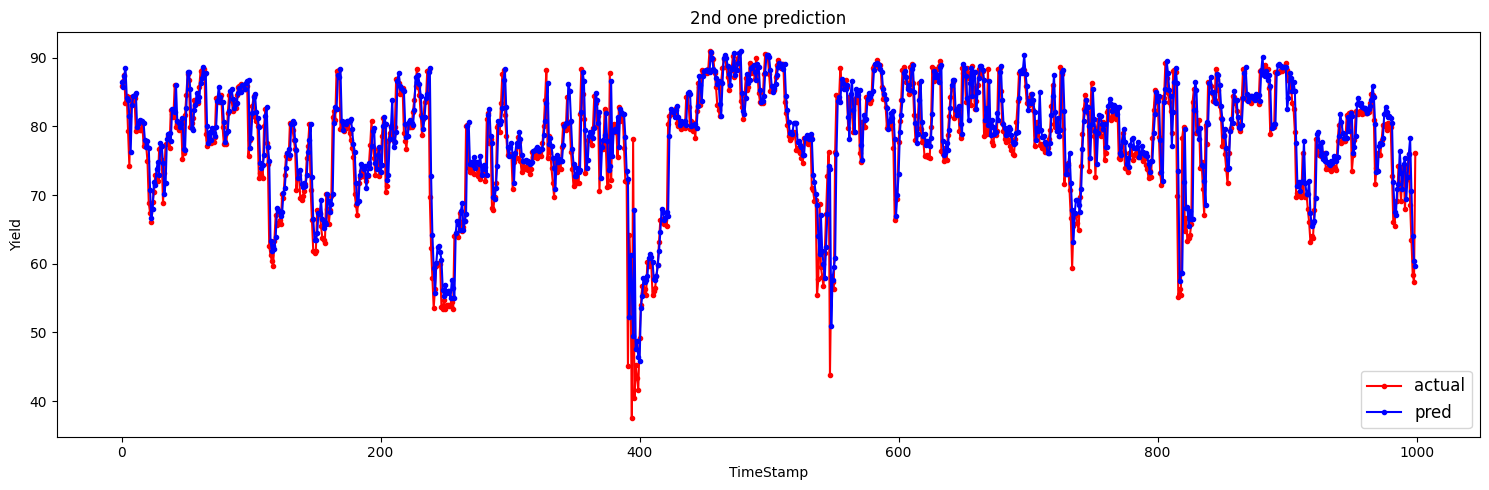

In [191]:
plt.figure(figsize=(15,5), dpi=100) #Figure size and dpi

plt.title('2nd one prediction')
plt.plot( np.arange(1000), actual[-1000:], label = 'actual', color = 'red', marker='o', linestyle = '-', markersize=3) # Real value
plt.plot( np.arange(1000), prediction_2[-1000:], label = 'pred', color = 'blue', marker='o', linestyle = '-', markersize=3) # Real value

plt.ylabel('Yield')
plt.xlabel('TimeStamp')
plt.legend(fontsize = 12, markerscale =1, loc = 'lower right')
plt.tight_layout()
plt.show()

## 데이터 바꾸기 (Input에 Target 포함 안시키기)

In [169]:
def time_slide_df_no_target(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.iloc[idx:idx+window_size,np.arange(1,25)].values.reshape(window_size, 24)
        y = df_[target].iloc[idx+window_size:idx+window_size+forcast_size-1].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data():
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [170]:
window_size = 8
forcast_size = 1
batch_size = 64
targets = 'SATURATOR_ML_SUPPLY_F_PV.Value'
date = 'TimeStamp'

train_n_x, train_n_y, train_n_date = time_slide_df_no_target(train, window_size, forcast_size, date, targets)
val_n_x, val_n_y, val_n_date = time_slide_df_no_target(valid, window_size, forcast_size, date, targets)
test_n_x, test_n_y, test_n_date = time_slide_df_no_target(test, window_size, forcast_size, date, targets)

In [171]:
train_n_ds = Data(train_n_x, train_n_y)
valid_n_ds = Data(val_n_x, val_n_y)
test_n_ds = Data(test_n_x, test_n_y)

train_n_dl = DataLoader(train_n_ds, batch_size = batch_size, shuffle=False)
valid_n_dl = DataLoader(valid_n_ds, batch_size = val_n_x.shape[0], shuffle=False)
test_n_dl  = DataLoader(test_n_ds,  batch_size = test_n_x.shape[0], shuffle=False)

In [182]:
class MultiStageForecasting_n(nn.Module):
    def __init__(self, len_stage1, len_stage2, len_stage3, window_size, forcast_size):
        super(MultiStageForecasting_n, self).__init__()
        self.len_stage1 = len_stage1
        self.len_stage2 = len_stage2
        self.len_stage3 = len_stage3
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.linear = nn.Linear(self.window_size, self.forcast_size)
        self.linear_st1 = nn.Linear(self.len_stage1, self.len_stage1//3)
        self.linear_st2 = nn.Linear(self.len_stage2 + self.len_stage1//3, (self.len_stage2 + self.len_stage1//3)//3)
        self.linear_st3 = nn.Linear((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3, 1)

        self.out_Linear = torch.nn.Linear(self.window_size, self.forcast_size)
        

    def forward(self, x):
        stage1 = x[:,:,:self.len_stage1]
        stage2 = x[:,:,self.len_stage1:self.len_stage1 + self.len_stage2]
        stage3 = x[:,:,self.len_stage1 + self.len_stage2: self.len_stage1 + self.len_stage2 + self.len_stage3]
        target_slide = x[:,:,self.len_stage1 + self.len_stage2 + self.len_stage3:]
        out_stage1 = self.linear_st1(stage1)
        stage2 = torch.cat([out_stage1,stage2],dim=2)
        out_stage2 = self.linear_st2(stage2)
        stage3 = torch.cat([out_stage2,stage3],dim=2)
        out_stage3 = self.linear_st3(stage3)

        x = self.out_Linear(out_stage3.permute(0,2,1)).permute(0,2,1)

        return x



In [183]:
### 모델 학습 ###
from tqdm.auto import tqdm

train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 100
lr = 0.001
model_n = MultiStageForecasting_n(len_stage1 = 9, len_stage2 = 12, len_stage3 = 3, window_size=window_size,
                            forcast_size=forcast_size,
                            ).to(device)
                            
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model_n.parameters(), lr=lr)
max_loss = 10**10

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    model_n.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model_n(data.to(device))
        loss = criterion(output.to(device), target.to(device).unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    model_n.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = model_n(data.to(device))
            valid_loss = criterion(output.to(device), target.to(device).unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        
        for data, target in test_dl:
            output = model_n(data.to(device))
            test_loss = criterion(output, target.to(device).unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss > max_loss: # loss가 개선되지 않은 경우
        patience_check += 1

        if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
            print('Early Stopping')
            break

    else: # loss가 개선된 경우
        max_loss = valid_loss
        patience_check = 0
    
    print("epoch = {}, train_loss(RMSE) : {:.3f}, valid_loss(RMSE) : {:.3f}, test_loss(RMSE) : {:.3f}".format(epoch,
                                                                                                                torch.sqrt(torch.mean(torch.Tensor(loss_list))),
                                                                                                                torch.sqrt(torch.Tensor(valid_loss)),
                                                                                                                torch.sqrt(torch.Tensor(test_loss))
                                                                                                                )
                                                                                                                )

  0%|          | 0/100 [00:00<?, ?it/s]

epoch = 1, train_loss(RMSE) : 18.612, valid_loss(RMSE) : 13.413, test_loss(RMSE) : 25.538
epoch = 2, train_loss(RMSE) : 13.518, valid_loss(RMSE) : 9.291, test_loss(RMSE) : 19.857
epoch = 3, train_loss(RMSE) : 11.324, valid_loss(RMSE) : 7.303, test_loss(RMSE) : 16.730
epoch = 4, train_loss(RMSE) : 9.942, valid_loss(RMSE) : 6.585, test_loss(RMSE) : 14.776
epoch = 5, train_loss(RMSE) : 8.861, valid_loss(RMSE) : 6.320, test_loss(RMSE) : 13.274
epoch = 6, train_loss(RMSE) : 7.971, valid_loss(RMSE) : 6.079, test_loss(RMSE) : 11.922
epoch = 7, train_loss(RMSE) : 7.252, valid_loss(RMSE) : 5.761, test_loss(RMSE) : 10.757
epoch = 8, train_loss(RMSE) : 6.723, valid_loss(RMSE) : 5.486, test_loss(RMSE) : 9.907
epoch = 9, train_loss(RMSE) : 6.369, valid_loss(RMSE) : 5.306, test_loss(RMSE) : 9.340
epoch = 10, train_loss(RMSE) : 6.126, valid_loss(RMSE) : 5.204, test_loss(RMSE) : 8.974
epoch = 11, train_loss(RMSE) : 5.953, valid_loss(RMSE) : 5.167, test_loss(RMSE) : 8.750
epoch = 12, train_loss(RMSE) :

In [184]:
model_n.eval()
prediction_n_1 = torch.cat([model_n(x.to(device)).detach().cpu() for x, y in test_dl], axis=0)
actual = torch.cat([y for x, y in test_dl], axis=0)
prediction_n_1 = prediction_n_1.squeeze().numpy()
actual = actual.squeeze().numpy()
mse_n_1 = sum((prediction_n_1-actual)**2)/len(prediction_n_1)
print(mse_n_1)

72.44852355787535


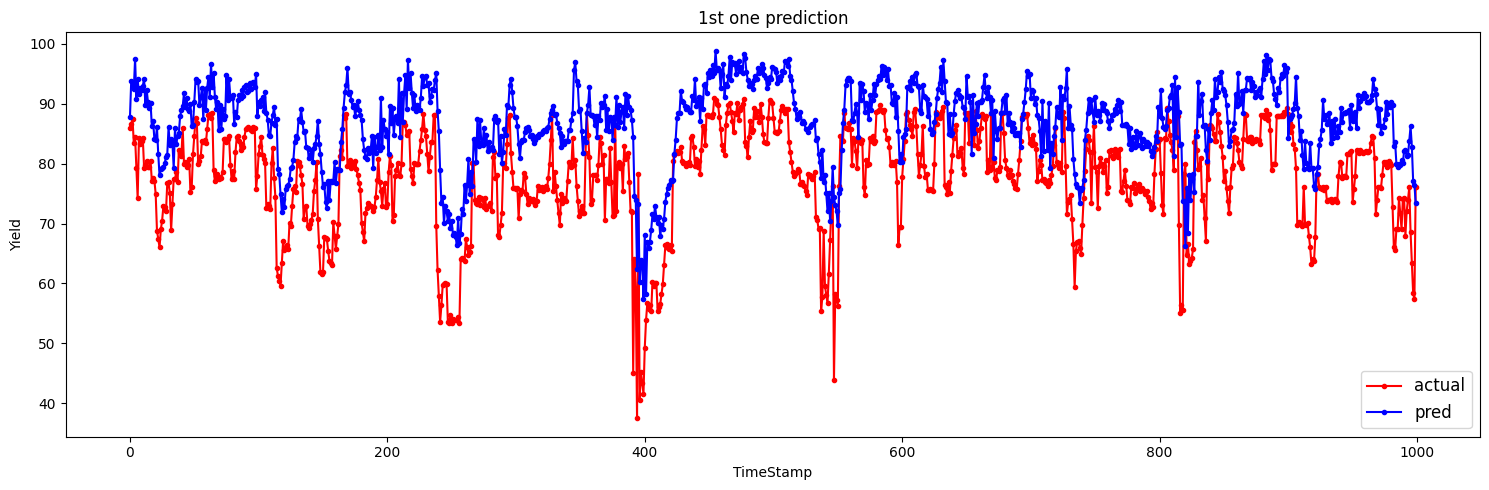

In [185]:
plt.figure(figsize=(15,5), dpi=100) #Figure size and dpi

plt.title('1st one prediction')
plt.plot( np.arange(1000), actual[-1000:], label = 'actual', color = 'red', marker='o', linestyle = '-', markersize=3) # Real value
plt.plot( np.arange(1000), prediction_n_1[-1000:], label = 'pred', color = 'blue', marker='o', linestyle = '-', markersize=3) # Real value

plt.ylabel('Yield')
plt.xlabel('TimeStamp')
plt.legend(fontsize = 12, markerscale =1, loc = 'lower right')
plt.tight_layout()
plt.show()

In [196]:
class MultiStageForecasting_n_2(nn.Module):
    def __init__(self, len_stage1, len_stage2, len_stage3, window_size, forcast_size):
        super(MultiStageForecasting_n_2, self).__init__()
        self.len_stage1 = len_stage1
        self.len_stage2 = len_stage2
        self.len_stage3 = len_stage3
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.linear = nn.Linear(self.window_size, self.forcast_size)
        self.linear_st1 = nn.Linear(self.len_stage1, self.len_stage1//3)
        self.linear_st2 = nn.Linear(self.len_stage2 + self.len_stage1//3, (self.len_stage2 + self.len_stage1//3)//3)
        self.linear_st3 = nn.Linear((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3, ((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2)

        self.Linears = torch.nn.ModuleList()
        for i in range(((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2):
            self.Linears.append(torch.nn.Linear(self.window_size, self.forcast_size))


        self.out_Linear = torch.nn.Linear(((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2, self.forcast_size)
        
        

    def forward(self, x):
        stage1 = x[:,:,:self.len_stage1]
        stage2 = x[:,:,self.len_stage1:self.len_stage1 + self.len_stage2]
        stage3 = x[:,:,self.len_stage1 + self.len_stage2: self.len_stage1 + self.len_stage2 + self.len_stage3]
        out_stage1 = self.linear_st1(stage1)
        stage2 = torch.cat([out_stage1,stage2],dim=2)
        out_stage2 = self.linear_st2(stage2)
        stage3 = torch.cat([out_stage2,stage3],dim=2)
        out = self.linear_st3(stage3)

        output = torch.zeros([out.size(0),self.forcast_size,out.size(2)],dtype=x.dtype).to(x.device)

        for i in range(((self.len_stage2 + self.len_stage1//3)//3 + self.len_stage3)//2):
            output[:,:,i] = self.Linears[i](out[:,:,i])

        x = self.out_Linear(output)
        
        return x



In [200]:
### 모델 학습 ###
from tqdm.auto import tqdm

train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 100
lr = 0.001
model_n_2 = MultiStageForecasting_n_2(len_stage1 = 9, len_stage2 = 12, len_stage3 = 3, window_size=window_size,
                            forcast_size=forcast_size,
                            ).to(device)
                            
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model_n_2.parameters(), lr=lr)
max_loss = 10**10

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    model_n_2.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model_n_2(data.to(device))
        loss = criterion(output.to(device), target.to(device).unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    model_n_2.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = model_n_2(data.to(device))
            valid_loss = criterion(output.to(device), target.to(device).unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        
        for data, target in test_dl:
            output = model_n_2(data.to(device))
            test_loss = criterion(output, target.to(device).unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss > max_loss: # loss가 개선되지 않은 경우
        patience_check += 1

        if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
            print('Early Stopping')
            break

    else: # loss가 개선된 경우
        max_loss = valid_loss
        patience_check = 0
    
    print("epoch = {}, train_loss(RMSE) : {:.3f}, valid_loss(RMSE) : {:.3f}, test_loss(RMSE) : {:.3f}".format(epoch,
                                                                                                                torch.sqrt(torch.mean(torch.Tensor(loss_list))),
                                                                                                                torch.sqrt(torch.Tensor(valid_loss)),
                                                                                                                torch.sqrt(torch.Tensor(test_loss))
                                                                                                                )
                                                                                                                )

  0%|          | 0/100 [00:00<?, ?it/s]

epoch = 1, train_loss(RMSE) : 8.656, valid_loss(RMSE) : 6.176, test_loss(RMSE) : 11.938
epoch = 2, train_loss(RMSE) : 6.783, valid_loss(RMSE) : 6.045, test_loss(RMSE) : 11.210
epoch = 3, train_loss(RMSE) : 6.252, valid_loss(RMSE) : 5.898, test_loss(RMSE) : 10.309
epoch = 4, train_loss(RMSE) : 5.977, valid_loss(RMSE) : 5.727, test_loss(RMSE) : 9.636
epoch = 5, train_loss(RMSE) : 5.834, valid_loss(RMSE) : 5.588, test_loss(RMSE) : 9.159
epoch = 6, train_loss(RMSE) : 5.757, valid_loss(RMSE) : 5.504, test_loss(RMSE) : 8.843
epoch = 7, train_loss(RMSE) : 5.724, valid_loss(RMSE) : 5.474, test_loss(RMSE) : 8.632
epoch = 8, train_loss(RMSE) : 5.692, valid_loss(RMSE) : 5.481, test_loss(RMSE) : 8.492
epoch = 9, train_loss(RMSE) : 5.662, valid_loss(RMSE) : 5.500, test_loss(RMSE) : 8.397
Early Stopping


In [201]:
model_n_2.eval()
prediction_n_2 = torch.cat([model_n_2(x.to(device)).detach().cpu() for x, y in test_dl], axis=0)
actual = torch.cat([y for x, y in test_dl], axis=0)
prediction_n_2 = prediction_n_2.squeeze().numpy()
actual = actual.squeeze().numpy()
mse_n_2 = sum((prediction_n_2-actual)**2)/len(prediction_n_2)
print(mse_n_2)

69.35584074790407


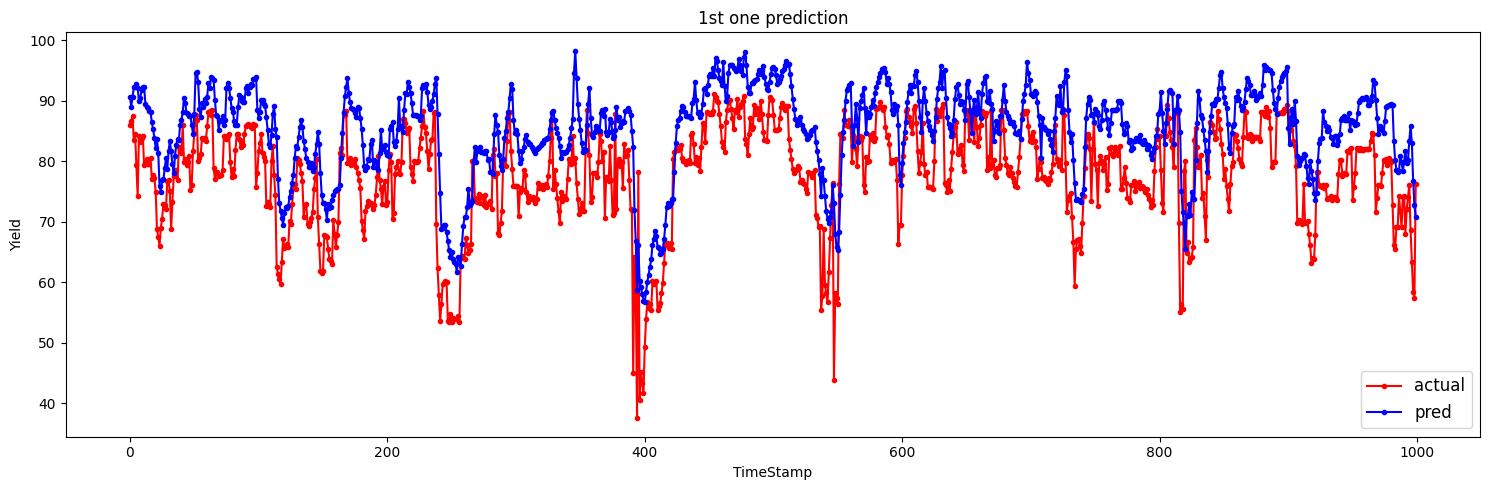

In [202]:
plt.figure(figsize=(15,5), dpi=100) #Figure size and dpi

plt.title('1st one prediction')
plt.plot( np.arange(1000), actual[-1000:], label = 'actual', color = 'red', marker='o', linestyle = '-', markersize=3) # Real value
plt.plot( np.arange(1000), prediction_n_2[-1000:], label = 'pred', color = 'blue', marker='o', linestyle = '-', markersize=3) # Real value

plt.ylabel('Yield')
plt.xlabel('TimeStamp')
plt.legend(fontsize = 12, markerscale =1, loc = 'lower right')
plt.tight_layout()
plt.show()